# HAIL TO THE TRANSFORMER!!
드디어

꺠알팁: 트랜스포머는 그냥 Adam 을 쓰고 lr을 조정해주지 않을 경우 초기 학습이 불안정하다. 이를 위해 lr을 키웠다가 줄이는 방식을 사용하거나, RAdam을 사용하면 해결할 수 있다 또한 FFN layer전에 normalization 을 해준다. 트랜스포머 논문에서 언급되지 않은 문제점이므로 기억해두도록하자 관련논문: 

## Positional encoding
문장을 이루는 각 단어들이 서로 얼마나 떨어져있는지에 대한 정보를 내포하기 위해서 사용한다.

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


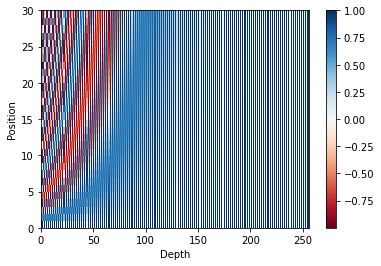

In [9]:
sample_pos_encoding = PositionalEncoding(30, 256)
# sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 256))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Attention!!
Query, Key, Value : 단어(정보를 함축한)벡터
-> seq2seq 모델에서 구성요소가 가지는 고유한 역할에 비교해보면 직관적으로 이해할 수 있을것같다.

어텐션 함수는 주어진 '쿼리'에 대해서 모든 '키'와의 유사도를 각각 구합니다. 그리고 구해낸 이 유사도를 키와 맵핑되어있는 각각의 값에 반영해줍니다. 그리고 유사도가 반영된 값을 모두 더해서 뭉쳐주면 이를 최종 결과인 '어텐션 값' 이라고 합니다.

1. Encoder self-attention
2. Masked decoder self-attention
3. Encoder-Decoder attention

### Self Attention
유사도를 구하는 대상이 현재 문장 내의 단어들과 서로 유사도를 구하는 방식

주어진 쿼리 Q에 대해 모든 키 K와의 유사도를 각각 계산한다. 이 유사도를 키와 맵핑되어있는 각각의 값 V에 반영하고, V를 모두 더해서 뭉쳐주면 어텐션 값 attention value를 얻을 수 있다.

In [12]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

In [15]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs


## Masking
### 패딩 마스킹 Padding masking

In [16]:
# 입력 시퀀스 중 0인 부분을 True(1)로 표기
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x,0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [17]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


### 룩 어헤드 마스킹 Look-ahead masking, 다음 단어 가리기
RNN을 사용한 시퀀셜 디코더의 경우 바로 앞 단어들만 참고하여 다음 단어를 예측한다\
트랜스포머의 경우 전체 문장이 행렬로 들어가면서 위치와 상관없이 모든 단어들을 참고해 다음 단어를 예측할 수 있다.\
우리가 원하는 것은 이전 단어들로부터 다음 단어를 예측하는 것이기 때문에 `자신보다 다음에 나올 단어를 참고하지 않도록 가리는 기법`

In [22]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    # padding mask + look ahead mask = maximum()
    return tf.maximum(look_ahead_mask, padding_mask)

In [21]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


## Encoder
`= 셀프어텐션 + 피드포워드 신경망`

In [25]:
def encoder_layer(units, d_model, num_heads, dropout, name='encoder_layer'):
    inputs = tf.keras.Input(shape=(None, d_model), name='inputs')
    
    padding_mask = tf.keras.Input(shape=(1,1,None), name='padding_mask')
    
    # 첫번째 서브 레이어 : 멀티헤드 어텐션(셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name='attention')({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })
    
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)
    
    # 두번째 서브 레이어 : 2개의 FCL
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)
    
    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 블록을 쌓아 인코더 만들기
(Encoder + Embedding Layer + Positional Encoding) * N = `TRANSFORMER ENCODER!!!`

In [28]:
def encoder(vocab_size,
           num_layers,
           units,
           d_model,
           num_heads,
           dropout,
           name='encoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    
    padding_mask = tf.keras.Input(shape=(1,1,None), name='padding_mask')
    
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='encoder_layer_{}'.format(i)
        )([outputs, padding_mask])
        
    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)


## Decoder
`= 셀프어텐션 + 인코더-디코더 어텐션 + 피드포워드신경망`

In [29]:
def decoder_layer(units, d_model, num_heads, dropout, name='decoder_layer'):
    inputs = tf.keras.Input(shape=(None, d_model), name='inputs')
    enc_ouputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 첫번쨰 서브 레이어 : 멀티헤드 어텐션 수행(셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name='attention_1')(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })
    
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + inputs)
    
    # 두번쨰 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행(인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name='attention_2')(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })
    
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)
    
    # 세번째 서브 레이어 : 2 개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)
    
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

### 레이어 쌓아 디코더 만들기
디코더 레이어 + 임베딩 층 + 포지셔널 인코딩

In [33]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None,d_model), name='encoder_outputs')
    look_ahead_mask = tf.kares.Input(
        shape=(1, None, None), name='look_ahead_mask')
    
    # Padding mask
    padding_mask = tf.keras.Input(shape=(1,1,None), name='padding_mask')
    
    # Embedding layer
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)    
    embeddings = tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # Positinal encoding
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i)
        )(inputs=[outputs, enc_ourputs, look_ahead_mask, padding_mask])
        
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

## 챗봇 병렬 데이터 받아오기
사람의 대화 : 응답하는 문장 
1. 50,000 개 질문-답 쌍을 추출
2. 문장에서 단어와 구두점 사이에 공백을 추가
3. 알파벳과 !?., 4개의 구두점을 제외하고 다른 특수문자를 모두 제거

### 데이터 다운로드

In [34]:
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin='http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset,'movie_conversations.txt')

9920512/9916637 [==============================] - 0s 0us/step


In [35]:
MAX_SAMPLES = 50000

In [36]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence


In [37]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
    id2line = {}
    with open(path_to_movie_lines, errors='ignore') as file:
        lines = file.readlines()
    for line in lines:
        parts = line.replace('\n', '').split(' +++$+++ ')
        id2line[parts[0]] = parts[4]

    inputs, outputs = [], []
    with open(path_to_movie_conversations, 'r') as file:
        lines = file.readlines()

    for line in lines:
        parts = line.replace('\n', '').split(' +++$+++ ')
        conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]

        for i in range(len(conversation) - 1):
            # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
            inputs.append(preprocess_sentence(id2line[conversation[i]]))
            outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))

            if len(inputs) >= MAX_SAMPLES:
                return inputs, outputs
    return inputs, outputs

In [38]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 50000
전체 샘플 수 : 50000
